In [1]:
using ITensors
#import KrylovKit 
#using KrylovKit
include("TamaTimeEvoMPS/src/TimeEvoMPS.jl")
using .TimeEvoMPS
include("TDVP_lib.jl")

createObs (generic function with 1 method)

In [2]:
using DelimitedFiles
coups = readdlm("Chain_mappings/WSCP_MC_T0_coups.dat");
freqs = readdlm("Chain_mappings/WSCP_MC_T0_freqs.dat");
#system energy gap
eps = 138.

138.0

In [3]:
sys = siteinds("S=1/2",1);
NChain = 86;
env = siteinds("Boson", dim=6, NChain);
NN = NChain + 1;
sysenv = vcat(sys,env);

In [4]:
stateSys = ["Up"];
stateEnv = ["0" for n=1:NChain];
stateSE = vcat(stateSys,stateEnv);
psi0 = productMPS(sysenv,stateSE);

In [5]:
length(sysenv)

87

In [6]:
#asymptotic frequency
MC_N = 6;
NP_Chain = NN - MC_N;
OO = 500.;
alphas_MC = readdlm("MC_Pars/alphas_6.dat")
betas_MC = readdlm("MC_Pars/betas_6.dat")
coups_MC = readdlm("MC_Pars/coupls_6.dat")
gammas = OO * alphas_MC[:,1];
eff_freq = [OO + 1im * g for g in gammas];
eff_gs = OO * betas_MC[:,2];
eff_coup = OO/2* (coups_MC[:,1]+ 1im *coups_MC[:,2]);


In [7]:
readdlm("MC_Pars/alphas_6.dat")[:,1]

6-element Vector{Float64}:
 -0.015996917837743683
 -1.4774047320945315e-10
 -2.175194571396893
 -1.4354113522679461e-11
 -0.004791119501886285
 -1.5738622265225956e-9

In [8]:
NP_Chain

21

In [8]:
#Lavoriamo qui
ampo = OpSum()
#system Hamiltonian
ampo += eps,"Sz",1;
#system-env interaction
#!Sx = 0.5 σx
ampo += 2*coups[1],"Sx",1,"Adag",2
ampo += 2*coups[1],"Sx",1,"A",2

#Primary chain local Hamiltonians
for j=2:NP_Chain
   ampo += freqs[j-1],"N",j
end

for j=2:NP_Chain-1
   ampo += coups[j],"A",j,"Adag",j+1
   ampo += coups[j],"Adag",j,"A",j+1
end
#################################

#Markovian closure Hamiltonian
for j=1:MC_N
   ampo += eff_freq[j],"N",NP_Chain+j
end

for j=1:MC_N-1
   ampo += eff_gs[j],"A",NP_Chain+j,"Adag",NP_Chain+j+1
   ampo += eff_gs[j],"Adag",NP_Chain+j,"A",NP_Chain+j+1
end

#################################

#Primary chain - MC interaction
for j=1:MC_N
   ampo += eff_coup[j],"A",NP_Chain,"Adag",NP_Chain+j
   ampo += conj(eff_coup[j]),"Adag",NP_Chain,"A",NP_Chain+j
end


H = MPO(ampo,sysenv); 

In [9]:
[dim(linkind(H,j)) for j in 1:length(H)-1];

In [13]:
vobs = []
push!(vobs,opPos("Sx",1))
push!(vobs,opPos("Sz",1))
nchain = collect(10:10:80)
for i in nchain 
   push!(vobs,opPos("N",i+1))
end

In [14]:
psi=deepcopy(psi0)
timestep = 0.0001
tmax = 0.10
cbT = LocalMeasurementCallbackTama(vobs,sysenv,10*timestep)

LocalMeasurementCallback
Operators: opPos[opPos("Sx", 1), opPos("Sz", 1), opPos("N", 11), opPos("N", 21), opPos("N", 31), opPos("N", 41), opPos("N", 51), opPos("N", 61), opPos("N", 71), opPos("N", 81)]
No measurements performed


In [15]:
tdvpMC!(psi,H,timestep,tmax,maxdim=20,callback=cbT, progress=true,cutoff=10e-10,io_file="critico.dat",store_psi0 = true,ranks_file = "ranghi.dat",times_file = "times.dat")

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/tama/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Evolving state...  10%|███▎                             |  ETA: 0:21:37
  t:             0.01
  dt step time:  1.535
  Max bond-dim:  4

LoadError: InterruptException:

## Plotting

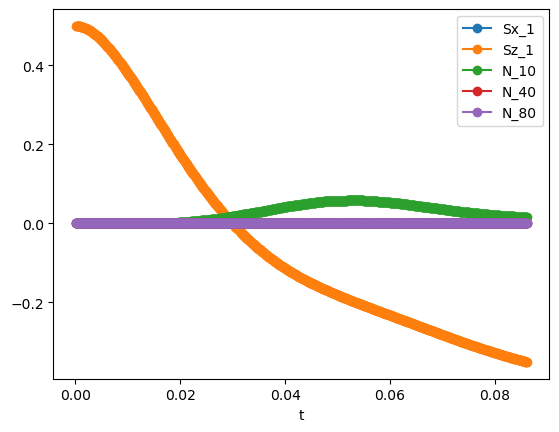

PyObject Text(0.5, 24.0, 't')

In [ ]:
using PyPlot
ts = measurement_ts(cbT)
for o in ["Sx_1","Sz_1","N_10","N_20"]
    S5 = getindex.(measurements(cbT)["$o"],1)
    plot(ts,S5,"-o",label="$o")
end
legend()
xlabel("t")

In [ ]:
psi[10]

ITensor ord=3 (dim=1|id=231|"Link,l=10") (dim=6|id=8|"Boson,Site,n=9") (dim=1|id=461|"Link,l=9")
ITensors.NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

IOStream(<file prova_sampa.dat>)

In [20]:
typeof(io)

IOStream

In [21]:
using Printf

In [30]:
io = open("prova_sampa.dat","a")
@printf(io,"%20s%20s%20s\n","tempo","ciao","mondo")
@printf(io,"%20f%20f%20f\n",10,20,30)
close(io)

LoadError: IOError: unlink("./prova_stampa.dat"): no such file or directory (ENOENT)